<a href="https://www.kaggle.com/code/nooralrajab/inter-cluster-figure-generation-ipynb?scriptVersionId=192821257" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

## Imports

In [32]:
input_directory="/kaggle/input"
output_directory="/kaggle/working"

In [33]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import explained_variance_score,max_error,mean_absolute_error,mean_squared_error,mean_squared_log_error,r2_score
from sklearn.linear_model import Lasso, Ridge, ElasticNet
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GroupKFold, GroupShuffleSplit
from sklearn import metrics
import matplotlib.pyplot as plt
import pickle
import scipy.stats as stats

## Choose descriptors

In [34]:
quant_func="median" # median or mean

X_raw=pd.read_excel(input_directory+"/log-transformed-prot-vs-rna/Inter-cluster_points.xlsx")
X_raw[['cellType', 'batchNum']] = X_raw[X_raw.columns[0]].str.split('-', expand=True)
X_raw = X_raw.drop(columns=[X_raw.columns[0]])
batch_raw=X_raw['batchNum']
cellType_raw=X_raw['cellType']
y_raw=X_raw["y_"+quant_func]
y_raw.columns=["Proteins"]
X_raw=X_raw[["Gene", "x_"+quant_func]]
X_raw.columns=["Gene", "Transcripts"]
display(X_raw)
display(y_raw)
display(batch_raw)
display(cellType_raw)

,Gene,Transcripts
0,VCAM1,0.000000
1,VCAM1,0.000000
2,VCAM1,0.000000
3,VCAM1,0.000000
4,VCAM1,0.000969
...,...,...
9499,KLRB1,0.453363
9500,KLRB1,0.013457
9501,KLRB1,0.030659
9502,KLRB1,0.035476


0       1.609438
1       1.386294
2       1.609438
3       1.609438
4       1.386294
          ...   
9499    1.386294
9500    0.693147
9501    0.693147
9502    0.693147
9503    0.693147
Name: y_median, Length: 9504, dtype: float64

0       b1
1       b1
2       b1
3       b1
4       b1
        ..
9499    b3
9500    b3
9501    b3
9502    b3
9503    b3
Name: batchNum, Length: 9504, dtype: object

0               CD16_mono
1                 B_naive
2               CD14_mono
3                     RBC
4                 NK_16hi
              ...        
9499                  DC3
9500    B_switched_memory
9501          B_exhausted
9502                  pDC
9503          HSC_CD38pos
Name: cellType, Length: 9504, dtype: object

## Remove genes with low variance

In [35]:
var_threshold=0.5

high_var_genes=[]

for g in X_raw["Gene"]:
    if((X_raw.loc[X_raw["Gene"]==g,"Transcripts"]>var_threshold).any()):
        high_var_genes.append(g)
        
high_var_genes=list(set(high_var_genes))
print(len(high_var_genes))

high_var_index=(X_raw["Gene"].isin(high_var_genes))
X=X_raw.loc[high_var_index].copy()
y=y_raw.loc[high_var_index].copy()
batch=batch_raw.loc[high_var_index].copy()
cellType=cellType_raw.loc[high_var_index].copy()
X.reset_index(inplace=True, drop=True)
y.reset_index(inplace=True, drop=True)
batch.reset_index(inplace=True, drop=True)
cellType.reset_index(inplace=True, drop=True)
display(X)
display(y)
display(batch)
display(cellType)

61


,Gene,Transcripts
0,NCR1,0.001974
1,NCR1,0.002198
2,NCR1,0.001640
3,NCR1,0.010559
4,NCR1,0.422711
...,...,...
4021,KLRB1,0.453363
4022,KLRB1,0.013457
4023,KLRB1,0.030659
4024,KLRB1,0.035476


0       1.098612
1       1.098612
2       1.098612
3       1.098612
4       1.609438
          ...   
4021    1.386294
4022    0.693147
4023    0.693147
4024    0.693147
4025    0.693147
Name: y_median, Length: 4026, dtype: float64

0       b1
1       b1
2       b1
3       b1
4       b1
        ..
4021    b3
4022    b3
4023    b3
4024    b3
4025    b3
Name: batchNum, Length: 4026, dtype: object

0               CD16_mono
1                 B_naive
2               CD14_mono
3                     RBC
4                 NK_16hi
              ...        
4021                  DC3
4022    B_switched_memory
4023          B_exhausted
4024                  pDC
4025          HSC_CD38pos
Name: cellType, Length: 4026, dtype: object

In [36]:
def orgMyPlots(subPlotsCount, columns=3):
    rows=np.ceil(float(subPlotsCount)/columns)
    x_ind=[]
    y_ind=[]
    
    for i in range(subPlotsCount):
        x_ind.append(i%columns)
        y_ind.append(int(np.floor(i/columns)))
    return x_ind, y_ind

### Run if you want to display specific genes

In [37]:
'''high_var_genes=['CD2', 'CD7', 'CD5', 'NCAM1', 'ITGAX', 'CD69', 'CXCR4', 'LAIR1']'''

"high_var_genes=['CD2', 'CD7', 'CD5', 'NCAM1', 'ITGAX', 'CD69', 'CXCR4', 'LAIR1']"

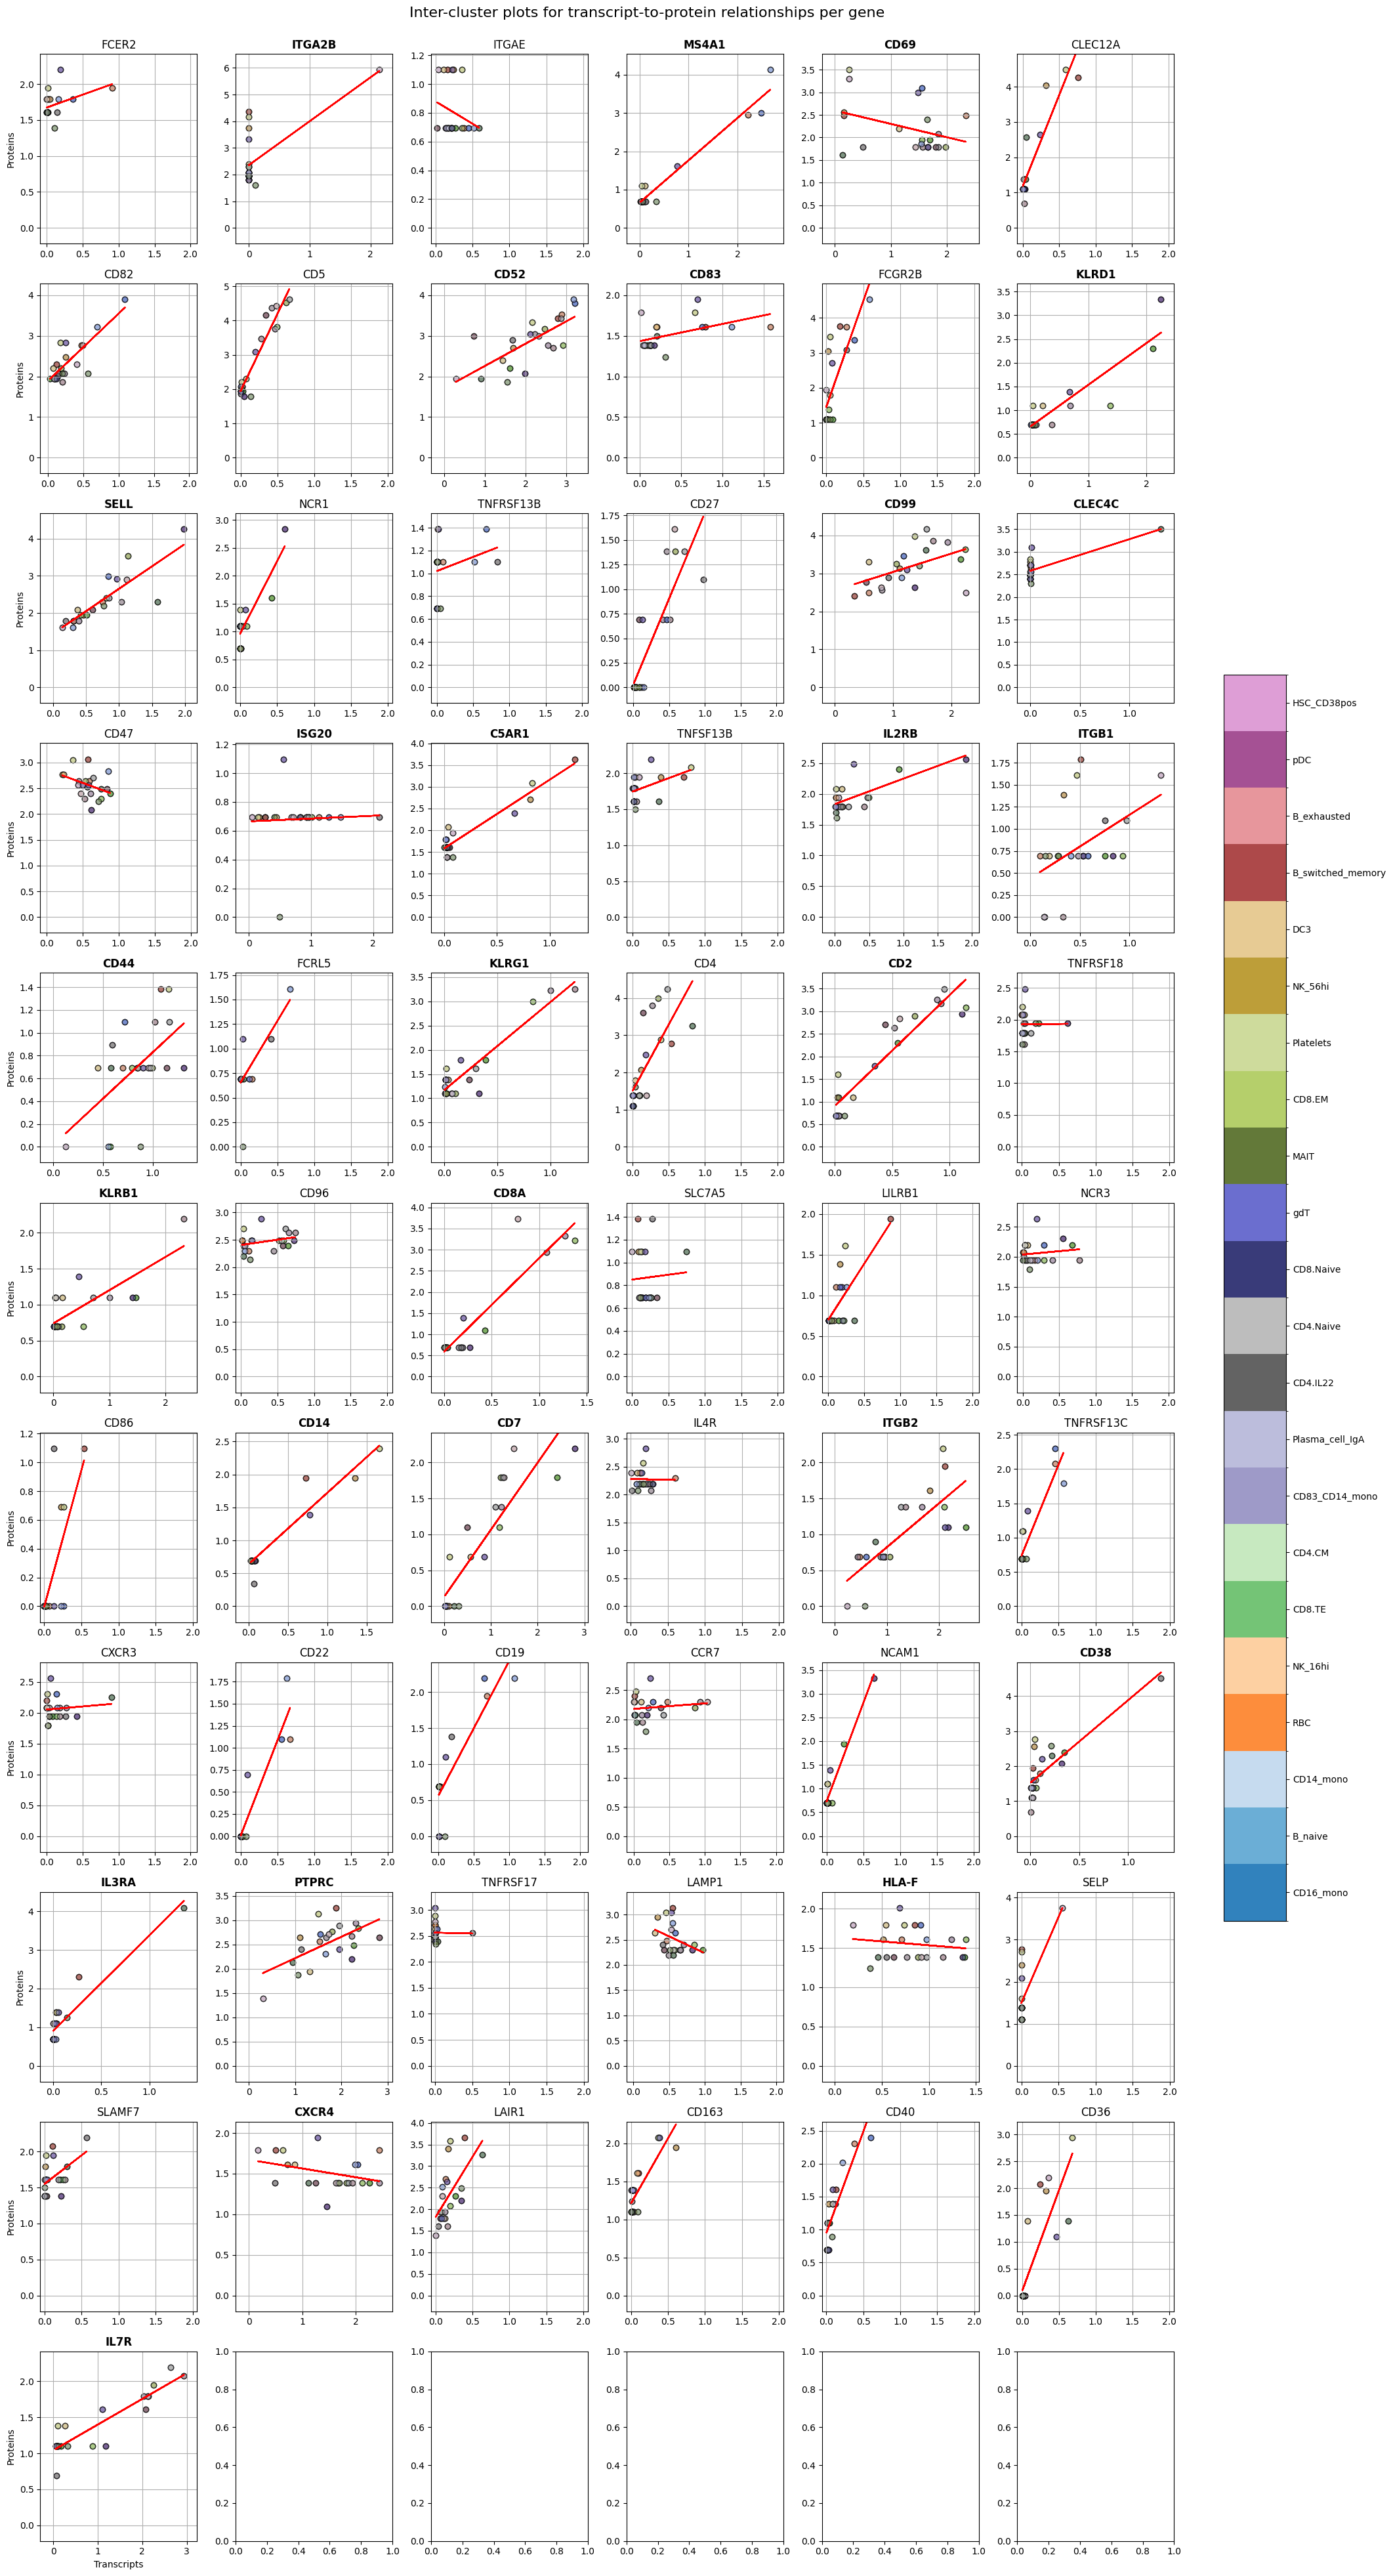

In [38]:
import matplotlib.colors as mcolors
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy import stats


cellTypes = cellType.unique()

x_ind, y_ind = orgMyPlots(len(high_var_genes), 6)
#plt.style.use('bmh')
fig, ax = plt.subplots(nrows=np.max(y_ind)+1, ncols=np.max(x_ind)+1, figsize=(4*np.array(x_ind).max(), 4*np.array(y_ind).max()))
r_vals = []
p_vals = []
slopes = []
intercepts = []
max_transcripts = []

# Create a combined colormap
tab20b = plt.get_cmap('tab20b')
tab20c = plt.get_cmap('tab20c')
colors_tab20b = tab20b(np.arange(tab20b.N))
colors_tab20c = tab20c(np.arange(tab20c.N))
combined_colors = np.vstack((colors_tab20c, colors_tab20b))

# Create a ListedColormap and BoundaryNorm for discrete colorbar
listed_cmap = mcolors.ListedColormap(combined_colors)
boundaries = np.arange(len(cellTypes)+1) - 0.5
norm = mcolors.BoundaryNorm(boundaries, listed_cmap.N, clip=True)

# Create a ScalarMappable object for colorbar
sm = plt.cm.ScalarMappable(cmap=listed_cmap, norm=norm)

for j, prot in enumerate(high_var_genes):
    gene_indicies = X["Gene"] == prot
    points = pd.concat({"x": X.loc[gene_indicies, "Transcripts"], "y": y.loc[gene_indicies]}, axis=1)
    points.dropna(inplace=True, how='any', axis=0)
    points.reset_index(inplace=True, drop=True)
    try:
        res = stats.linregress(points['x'], points['y'])
        slopes.append(res.slope)
        intercepts.append(res.intercept)
        r_vals.append(res.rvalue)
        p_vals.append(res.pvalue)
    except:
        slopes.append(np.nan)
        intercepts.append(np.nan)
        r_vals.append(np.nan)
        p_vals.append(np.nan)
        
    if y_ind[j] == np.max(y_ind):
        ax[y_ind[j], x_ind[j]].set_xlabel("Transcripts")
    if x_ind[j] == 0:
        ax[y_ind[j], x_ind[j]].set_ylabel("Proteins")
        
    if points['x'].max() > np.log1p(2):
        ax[y_ind[j], x_ind[j]].set_title(prot, fontweight='bold')
        max_x = points['x'].max()
    else:
        ax[y_ind[j], x_ind[j]].set_title(prot)
        max_x = 2
        
    try:
        paddingx = points['x'].max()/10
        paddingy = points['y'].max()/10
        ax[y_ind[j], x_ind[j]].set_xlim(0-paddingx, max_x+paddingx)
        ax[y_ind[j], x_ind[j]].set_ylim(0-paddingy, points['y'].max()+paddingy)
    except:
        pass
    
    for i, txt in enumerate(points.index):
        ax[y_ind[j], x_ind[j]].scatter(points['x'].values[i], points['y'].values[i], alpha=0.5, color=combined_colors[i % len(combined_colors)], edgecolors='k')
    ax[y_ind[j], x_ind[j]].plot(points['x'].values, res.intercept + res.slope * points['x'], c='r')
    max_transcripts.append(points['x'].max())
    ax[y_ind[j], x_ind[j]].grid(True)
        
fig.suptitle("Inter-cluster plots for transcript-to-protein relationships per gene", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.98])

# Add discrete colorbar
cbar = fig.colorbar(sm, ax=ax.ravel().tolist(), orientation='vertical', fraction=0.05, pad=0.04)
cbar.set_ticks(np.arange(len(cellTypes)))
cbar.set_ticklabels(cellTypes)

plt.show()
fig.savefig("Inter-cluster_by_cell_type.png", bbox_inches='tight')

# Save regression results if needed
# regressResults = pd.DataFrame({"Gene": high_var_genes, "Slope": slopes, "Intercept": intercepts, "R-Value": r_vals, "P-Value": p_vals, "Max_Transcripts": max_transcripts})
# regressResults.to_excel("Regression_Results.xlsx")


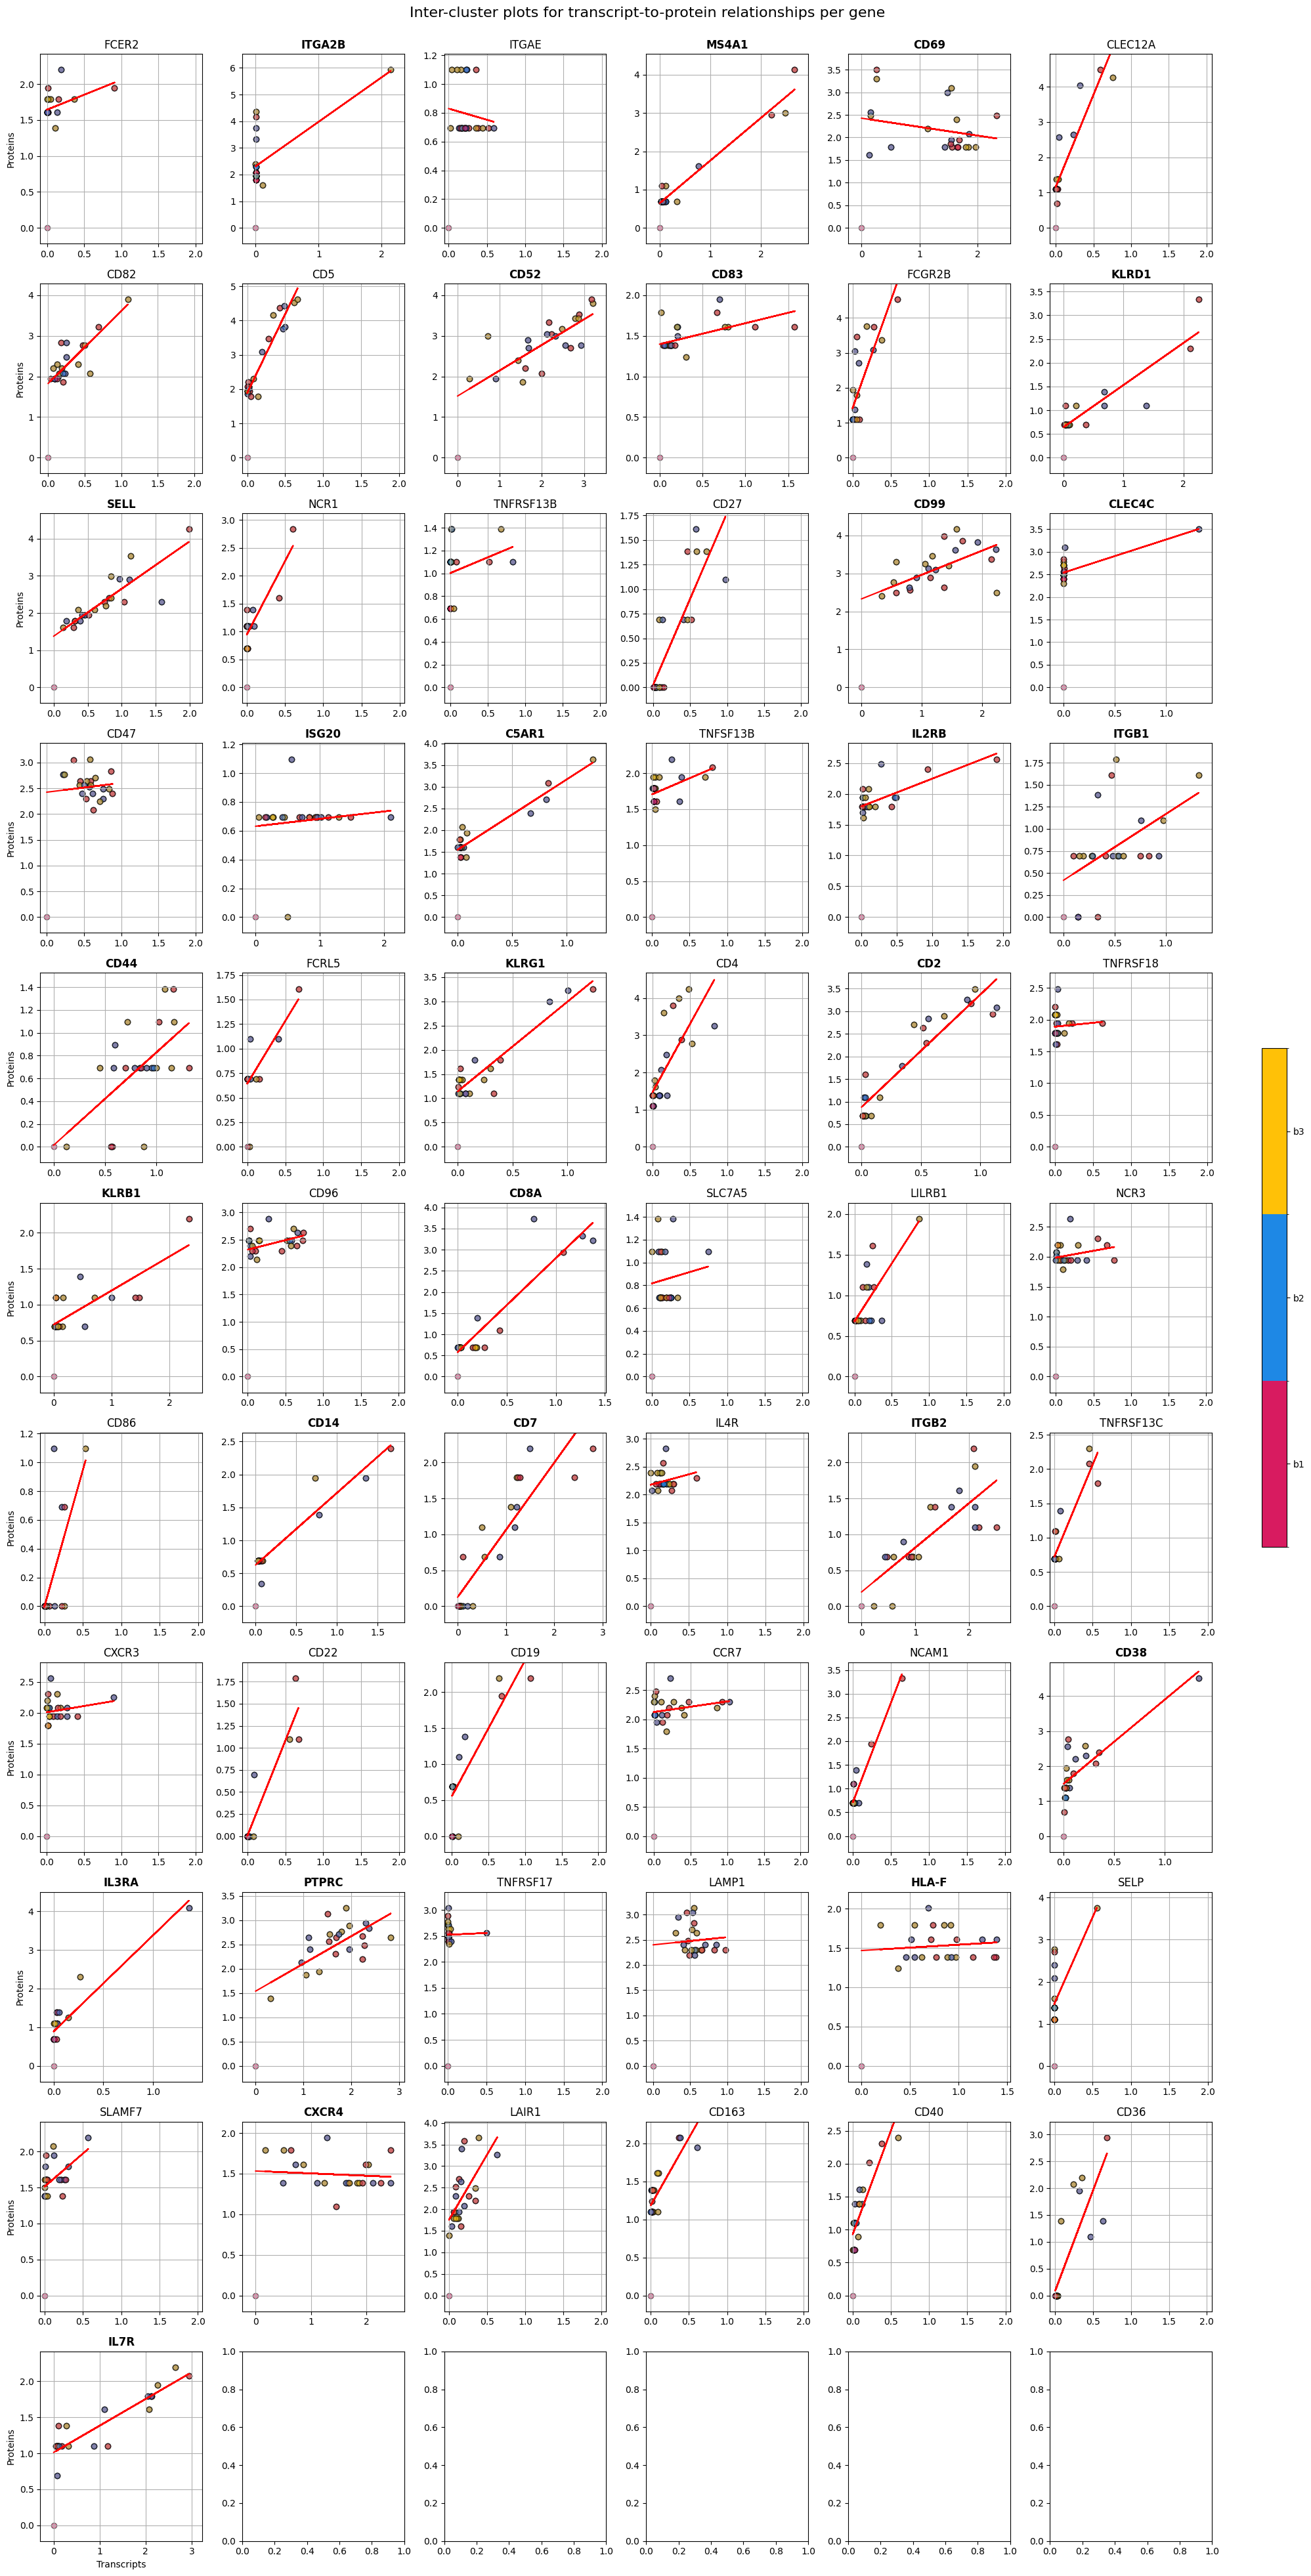

In [39]:
import matplotlib.colors as mcolors
x_ind, y_ind=orgMyPlots(len(high_var_genes),6)
#plt.style.use('bmh')
fig, ax = plt.subplots(nrows=np.max(y_ind)+1, ncols=np.max(x_ind)+1, figsize=(4*np.array(x_ind).max(), 4*np.array(y_ind).max()))
r_vals=[]
p_vals=[]
slopes=[]
intercepts=[]
max_transcripts=[]
# Create a colormap
batches = batch.unique()
colors = ['#D81B60', '#1E88E5', '#FFC107']
#cmap = plt.get_cmap('tab10')
#colors = cmap(np.linspace(0, 1, len(batches)))  # Get an array of colors
color_map = {b: colors[i] for i, b in enumerate(batches)}

cmap = mcolors.ListedColormap(colors)
norm = mcolors.BoundaryNorm(boundaries=[0, 1, 2, 3], ncolors=len(colors))
# Create a ScalarMappable object for colorbar
#norm = mcolors.Normalize(vmin=0, vmax=len(batches)-1)
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
for j, prot in enumerate(high_var_genes):
    gene_indicies=X["Gene"]==prot
    points=pd.concat({"x": X.loc[gene_indicies, "Transcripts"], "y": y.loc[gene_indicies]}, axis=1)
    points.dropna(inplace=True,how='any',axis=0)
    zeros=pd.DataFrame([{'x':0, 'y':0}])
    points=pd.concat([points,zeros], axis=0)
    points.reset_index(inplace=True, drop=True)
    try:
        res=stats.linregress(points['x'], points['y'])
        slopes.append(res.slope)
        intercepts.append(res.intercept)
        r_vals.append(res.rvalue)
        p_vals.append(res.pvalue)
        
    except:
        slopes.append(np.nan)
        intercepts.append(np.nan)
        r_vals.append(np.nan)
        p_vals.append(np.nan)
    if(y_ind[j]==np.max(y_ind)):
        ax[y_ind[j],x_ind[j]].set_xlabel("Transcripts")
    if(x_ind[j]==0):
        ax[y_ind[j],x_ind[j]].set_ylabel("Proteins")
        
        
    if(points['x'].max()>np.log1p(2)):
        ax[y_ind[j],x_ind[j]].set_title(prot, fontweight='bold')
        max_x=points['x'].max()
    else:
        ax[y_ind[j],x_ind[j]].set_title(prot)
        max_x=2
        
    try:
        paddingx=points['x'].max()/10
        paddingy=points['y'].max()/10
        ax[y_ind[j],x_ind[j]].set_xlim(0-paddingx,max_x+paddingx)
        ax[y_ind[j],x_ind[j]].set_ylim(0-paddingy,points['y'].max()+paddingy)
    except:
        pass
    
    for i, txt in enumerate(points.index):
        ax[y_ind[j],x_ind[j]].scatter(points['x'].values[i], points['y'].values[i], alpha=0.5, color=colors[i % len(colors)], edgecolors='k')
    ax[y_ind[j],x_ind[j]].plot(points['x'].values,res.intercept+res.slope*points['x'], c='r')
    #ax[y_ind[j],x_ind[j]].scatter(0, 0, alpha=1, color='r')
    max_transcripts.append(points['x'].max())
    ax[y_ind[j], x_ind[j]].grid(True)
        
#fig.colorbar()
fig.suptitle("Inter-cluster plots for transcript-to-protein relationships per gene", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.98])
cbar = fig.colorbar(sm, ax=ax.ravel().tolist(), orientation='vertical', fraction=0.02, pad=0.04)
cbar.set_ticks([0.5, 1.5, 2.5])
cbar.set_ticklabels(batches)
plt.show()
fig.savefig("Inter-cluster_by_batch.png", bbox_inches='tight')

#regressResults=pd.DataFrame({"Gene": high_var_genes, "Slope": slopes, "Intercept": intercepts, "R-Value": r_vals, "P-Value": p_vals, "Max_Transcripts": max_transcripts})
#regressResults.to_excel("Regression_Results.xlsx")

In [40]:
!pip install protpy
!pip install biopython

In [41]:
from Bio import SeqIO
import protpy as protpy
import numpy as np

def get_fasta(geneList):
    gene_to_seq = {}
    sequences=[]
    geneList=list(geneList)
    successfulGenes=[]

    for record in SeqIO.parse(input_directory+"/uniprot-swissprot-fasta/uniprot_sprot.fasta", "fasta"):
        org=record.name.split("|")[2].split("_")[1]
        try:
            gene=record.description.split("GN=")[1].split(" ")[0]
        except Exception as e:
            print(e)
            gene=record.name.split("|")[2].split("_")[0]
        if(org == "HUMAN" and gene in geneList):
            gene_to_seq[gene]=record.seq
            #print(gene_to_seq)
    for gene in geneList:
        try:
            new_seq=gene_to_seq[gene]
            sequences.append(new_seq)
            successfulGenes.append(gene)
        except Exception as e:
            print(e)
    return sequences, successfulGenes

prots=X["Gene"].unique()
seqs, genes_found=get_fasta(prots) # use genes in common between surface markers and dataset
desc_lookup=pd.DataFrame({"Gene": genes_found, "FASTA": seqs})
descList=[]
for seq in seqs:
    descList.append(protpy.dipeptide_composition(str(seq)))
desc_lookup=desc_lookup.join(pd.DataFrame(np.squeeze(descList)))
desc_lookup.drop("FASTA", inplace=True, axis=1)
desc_lookup.set_index("Gene", inplace=True)
display(desc_lookup)

list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out o

,0,1,2,3,4,5,6,7,8,9,...,390,391,392,393,394,395,396,397,398,399
Gene,,,,,,,,,,,,,,,,,,,,,
NCR1,0.00,0.00,0.33,0.66,0.33,0.33,0.33,0.00,0.00,0.99,...,0.00,0.33,0.00,0.33,0.66,0.33,0.00,0.00,0.00,0.0
IL4R,0.49,0.00,0.24,0.00,0.12,0.61,0.24,0.12,0.24,0.12,...,0.24,0.36,0.12,0.24,0.36,0.12,0.12,0.12,0.00,0.0
FCGR2B,0.97,0.00,0.65,0.32,0.00,0.32,0.00,0.32,0.00,0.97,...,0.00,0.00,0.32,0.00,0.32,0.65,0.65,0.00,0.00,0.0
CD2,0.29,0.00,0.00,0.29,0.00,0.29,0.29,0.00,0.29,0.86,...,0.00,0.00,0.00,0.29,0.00,0.00,0.00,0.00,0.00,0.0
TNFRSF13C,0.55,0.55,0.00,1.09,0.00,2.19,0.00,0.00,0.00,2.73,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
IL3RA,0.27,0.00,0.53,0.27,0.27,0.80,0.00,0.27,0.53,0.80,...,0.00,0.00,0.00,0.00,0.00,0.27,0.53,0.00,0.00,0.0
CD86,0.30,0.00,0.30,0.00,0.30,0.00,0.00,0.00,0.00,0.00,...,0.30,0.00,0.30,0.30,0.00,0.00,0.00,0.00,0.00,0.0
CD5,0.40,0.00,0.00,0.20,0.00,1.01,0.00,0.00,0.00,1.01,...,0.00,0.00,0.20,0.00,0.20,0.40,0.20,0.00,0.00,0.0


In [42]:
import pickle
def get_abundances(transcripts_per_gene_df): # takes a dataframe where indicies are gene names and one column (transcripts)
    #X_desc=desc_lookup.copy()
    X_desc=[]
    geneList=transcripts_per_gene_df["Gene"]
    for gene in geneList:
        X_desc.append(desc_lookup.loc[gene])
    X_desc=pd.DataFrame(X_desc)
    X_desc.reset_index(inplace=True, drop=True)
    display(X_desc)
    X_desc=X_desc.mul(transcripts_per_gene_df["Transcripts"], axis=0)
    #transcripts_per_gene_df=transcripts_per_gene_df.to_frame()
    X=transcripts_per_gene_df.join(X_desc, how='inner') # based on index
    X.drop("Gene", inplace=True, axis=1)
    X.columns = X.columns.astype(str)
    
    # ridge model
    model_file = open(input_directory+"/protein_abundance_predictor/scikitlearn/ridge/2/Ridge_Protein_Abundance_Predictor.sav",'rb')
    model = pickle.load(model_file)
    model_file.close()
    y_ridge=model.predict(X)
    
    # random forest model
    model_file = open(input_directory+"/protein_abundance_predictor/scikitlearn/default/1/Protein_Abundance_Predictor.sav",'rb')
    model = pickle.load(model_file)
    model_file.close()
    y_rf=model.predict(X)
    y=pd.DataFrame({"Gene": geneList, "Transcripts":transcripts_per_gene_df["Transcripts"], "Proteins_Ridge": y_ridge, "Proteins_RF": y_rf})
    return y


pred_df=get_abundances(X)
display(pred_df)

,0,1,2,3,4,5,6,7,8,9,...,390,391,392,393,394,395,396,397,398,399
0,0.0,0.0,0.33,0.66,0.33,0.33,0.33,0.00,0.00,0.99,...,0.0,0.33,0.00,0.33,0.66,0.33,0.0,0.0,0.00,0.0
1,0.0,0.0,0.33,0.66,0.33,0.33,0.33,0.00,0.00,0.99,...,0.0,0.33,0.00,0.33,0.66,0.33,0.0,0.0,0.00,0.0
2,0.0,0.0,0.33,0.66,0.33,0.33,0.33,0.00,0.00,0.99,...,0.0,0.33,0.00,0.33,0.66,0.33,0.0,0.0,0.00,0.0
3,0.0,0.0,0.33,0.66,0.33,0.33,0.33,0.00,0.00,0.99,...,0.0,0.33,0.00,0.33,0.66,0.33,0.0,0.0,0.00,0.0
4,0.0,0.0,0.33,0.66,0.33,0.33,0.33,0.00,0.00,0.99,...,0.0,0.33,0.00,0.33,0.66,0.33,0.0,0.0,0.00,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4021,0.0,0.0,0.45,0.45,0.00,0.45,0.00,0.89,0.45,0.45,...,0.0,0.00,0.45,0.00,0.00,0.45,0.0,0.0,0.45,0.0
4022,0.0,0.0,0.45,0.45,0.00,0.45,0.00,0.89,0.45,0.45,...,0.0,0.00,0.45,0.00,0.00,0.45,0.0,0.0,0.45,0.0
4023,0.0,0.0,0.45,0.45,0.00,0.45,0.00,0.89,0.45,0.45,...,0.0,0.00,0.45,0.00,0.00,0.45,0.0,0.0,0.45,0.0
4024,0.0,0.0,0.45,0.45,0.00,0.45,0.00,0.89,0.45,0.45,...,0.0,0.00,0.45,0.00,0.00,0.45,0.0,0.0,0.45,0.0


,Gene,Transcripts,Proteins_Ridge,Proteins_RF
0,NCR1,0.001974,0.009366,1.206446
1,NCR1,0.002198,0.010427,1.206446
2,NCR1,0.001640,0.007779,1.222037
3,NCR1,0.010559,0.050093,1.257723
4,NCR1,0.422711,2.005292,1.971778
...,...,...,...,...
4021,KLRB1,0.453363,0.445025,1.453251
4022,KLRB1,0.013457,0.013209,1.169215
4023,KLRB1,0.030659,0.030095,1.173916
4024,KLRB1,0.035476,0.034823,1.174872


### Run if you want to display specific genes

In [43]:
'''high_var_genes=['CD7', 'ITGA2B', 'LAIR1', 'IL3RA', 'CD40', 'LGALS3', 'CXCR3', 'CD44', 'ITGAE']'''

"high_var_genes=['CD7', 'ITGA2B', 'LAIR1', 'IL3RA', 'CD40', 'LGALS3', 'CXCR3', 'CD44', 'ITGAE']"

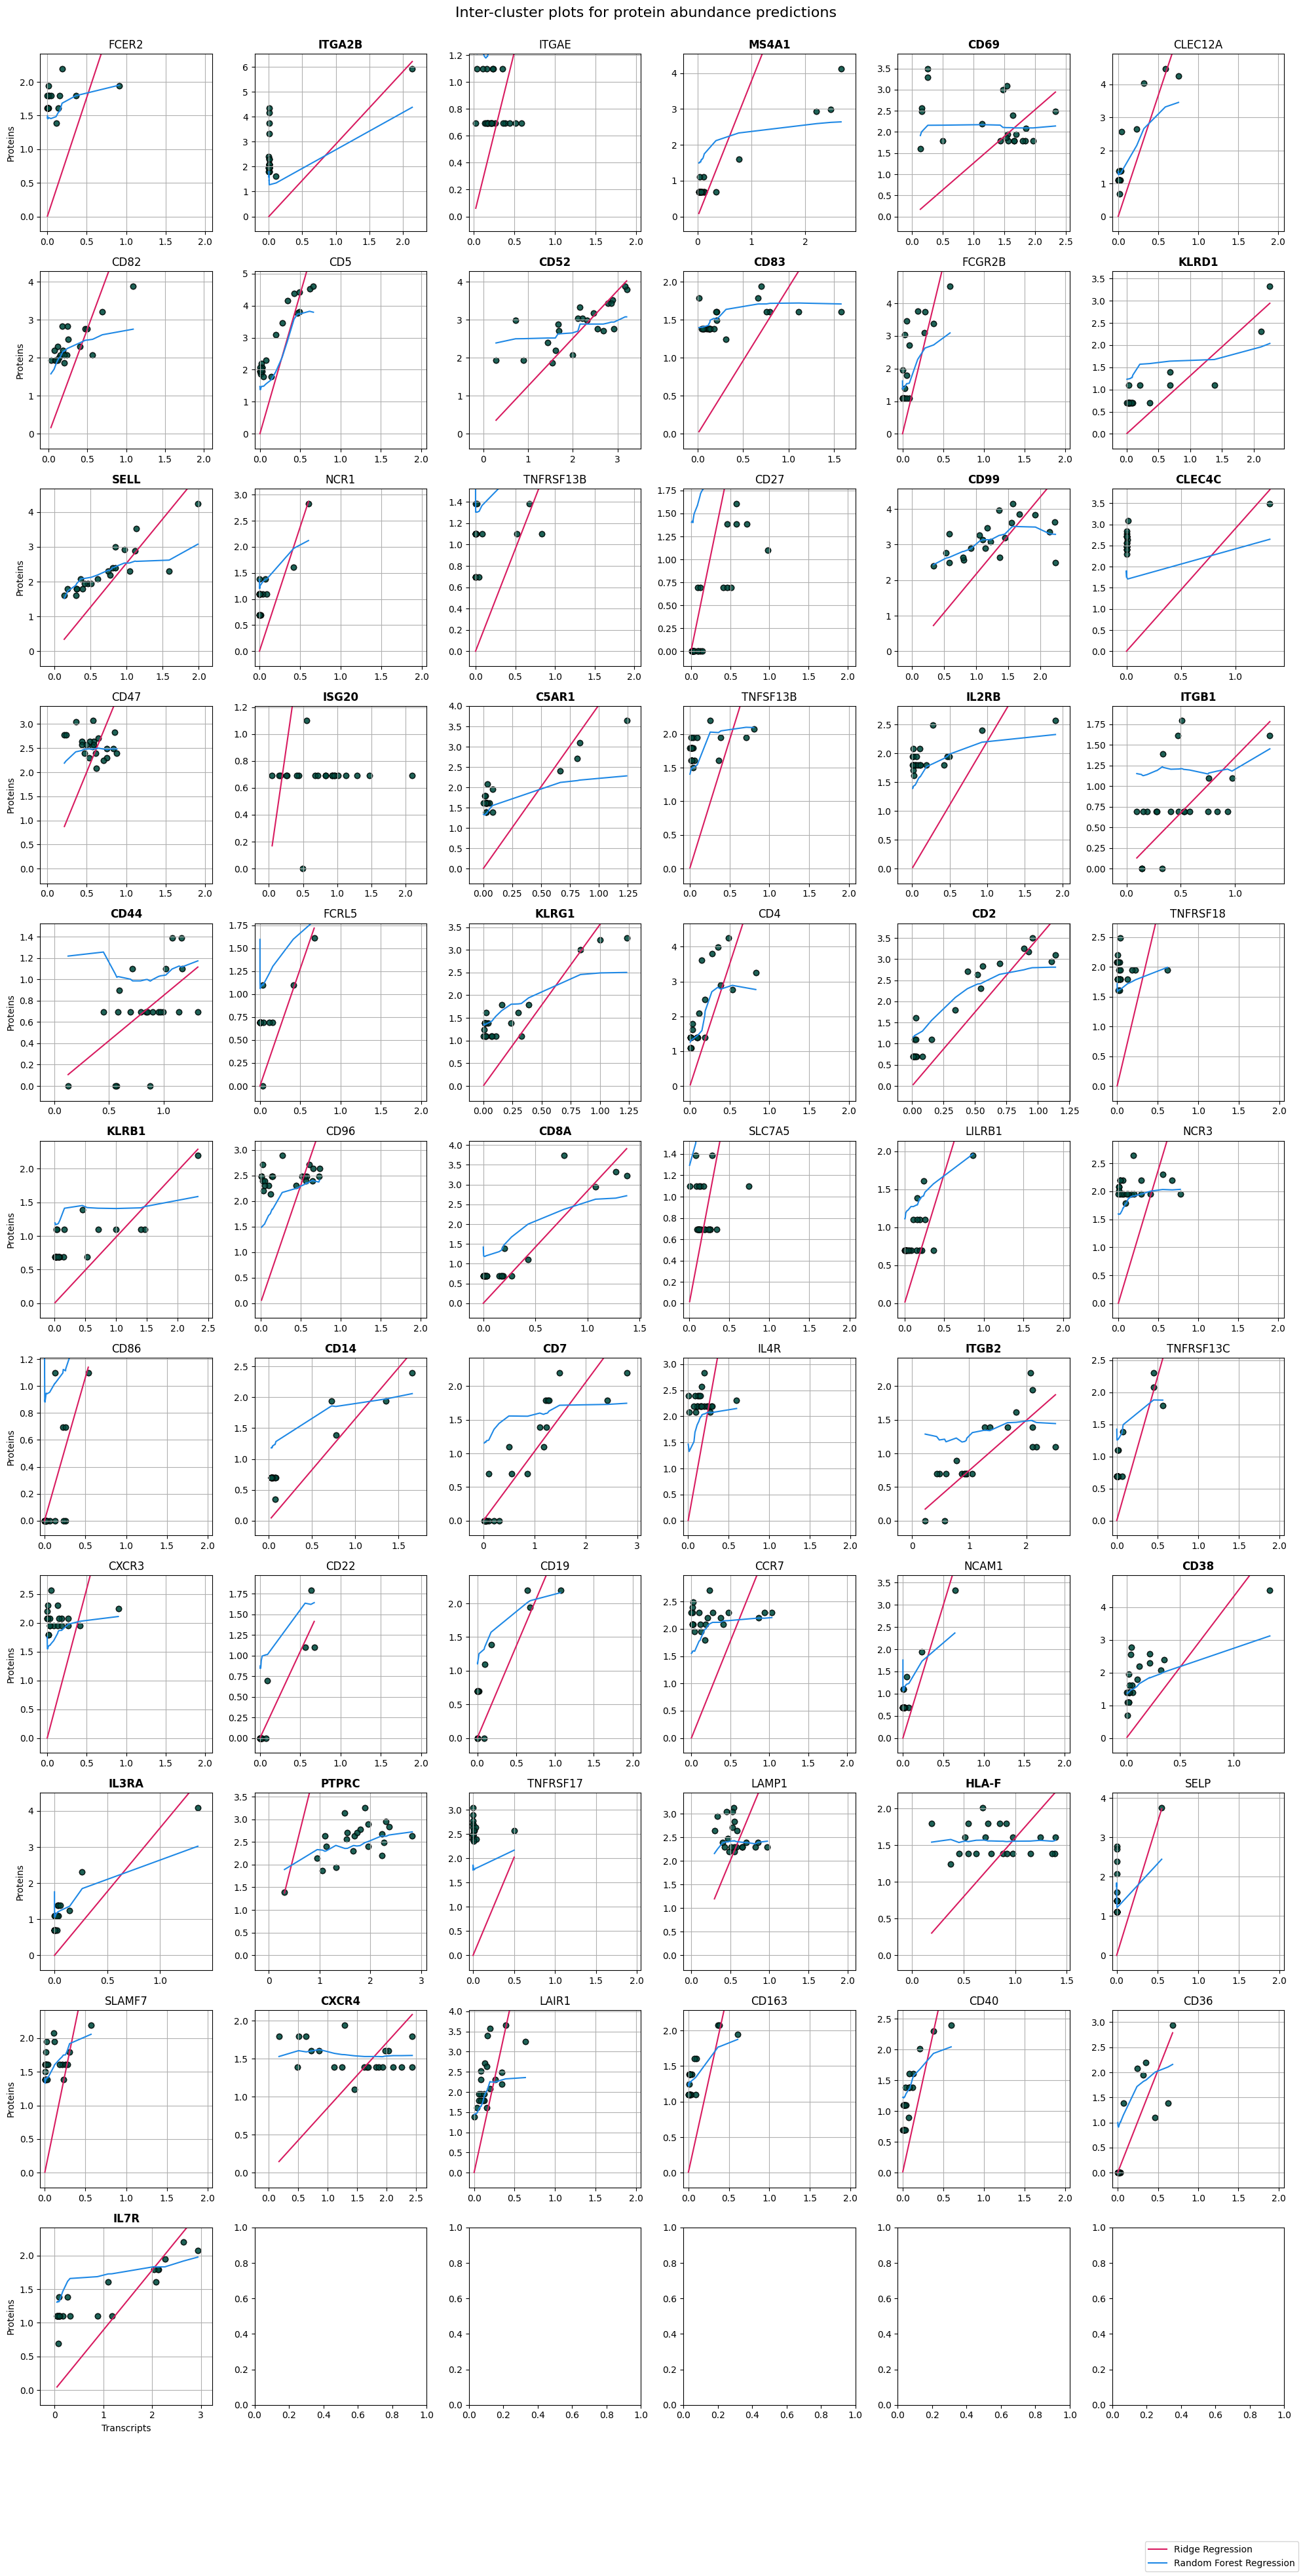

In [44]:
import matplotlib.colors as mcolors
x_ind, y_ind=orgMyPlots(len(high_var_genes),6)
#plt.style.use('bmh')
fig, ax = plt.subplots(nrows=np.max(y_ind)+1, ncols=np.max(x_ind)+1, figsize=(4*np.array(x_ind).max(), 4*np.array(y_ind).max()))
r_vals=[]
p_vals=[]
slopes=[]
intercepts=[]
max_transcripts=[]
# Create a colormap
cellTypes = cellType.unique()

for j, prot in enumerate(high_var_genes):
    gene_indicies=X["Gene"]==prot
    points=pd.concat({"x": X.loc[gene_indicies, "Transcripts"], "y": y.loc[gene_indicies]}, axis=1)
    points.dropna(inplace=True,how='any',axis=0)
    pred=pred_df.loc[pred_df["Gene"]==prot, ['Transcripts', 'Proteins_Ridge', 'Proteins_RF']].copy()
    pred.sort_values(inplace=True, ascending=True, by="Transcripts")
    #zeros=pd.DataFrame([{'x':0, 'y':0}])
    #points=pd.concat([points,zeros], axis=0)
    points.reset_index(inplace=True, drop=True)
    if(y_ind[j]==np.max(y_ind)):
        ax[y_ind[j],x_ind[j]].set_xlabel("Transcripts")
    if(x_ind[j]==0):
        ax[y_ind[j],x_ind[j]].set_ylabel("Proteins")
        
        
    if(points['x'].max()>np.log1p(2)):
        ax[y_ind[j],x_ind[j]].set_title(prot, fontweight='bold')
        max_x=points['x'].max()
    else:
        ax[y_ind[j],x_ind[j]].set_title(prot)
        max_x=2
        
    try:
        paddingx=points['x'].max()/10
        paddingy=points['y'].max()/10
        ax[y_ind[j],x_ind[j]].set_xlim(0-paddingx,max_x+paddingx)
        ax[y_ind[j],x_ind[j]].set_ylim(0-paddingy,points['y'].max()+paddingy)
    except:
        pass
    
    for i, txt in enumerate(points.index):
        ax[y_ind[j],x_ind[j]].scatter(points['x'].values[i], points['y'].values[i], alpha=0.5, color='#004D40', edgecolor='k')
    ax[y_ind[j],x_ind[j]].plot(pred["Transcripts"],pred["Proteins_Ridge"], c='#D81B60', label='Ridge Regression')
    ax[y_ind[j],x_ind[j]].plot(pred["Transcripts"],pred["Proteins_RF"], c='#1E88E5', label='Random Forest Regression')
    #ax[y_ind[j],x_ind[j]].scatter(0, 0, alpha=1, color='r')
    max_transcripts.append(points['x'].max())
    ax[y_ind[j], x_ind[j]].grid(True)
        
#fig.colorbar()
fig.suptitle("Inter-cluster plots for protein abundance predictions", fontsize=16)
handles, labels = ax[0][0].get_legend_handles_labels()
fig.legend(handles, labels, loc='lower right')
plt.tight_layout(rect=[0, 0.05, 1, 0.98])
plt.show()
fig.savefig("Inter-cluster_predictions.png", bbox_inches='tight')

#regressResults=pd.DataFrame({"Gene": high_var_genes, "Slope": slopes, "Intercept": intercepts, "R-Value": r_vals, "P-Value": p_vals, "Max_Transcripts": max_transcripts})
#regressResults.to_excel("Regression_Results.xlsx")